# **taL(LM)ent show**

This project stages a talent show designed to explore and compare different prompt engineering strategies across multiple large language models.

Two fictional artists, with distinct creative identities, present parts of their most representative works. Their performances are evaluated by three judges, each representing unique evaluation styles, while a host provides a compelling synthesis of the judges’ remarks.

With each round, the judges’ rules evolve, reflecting changes in prompting techniques, and every set of performances is tested on different LLMs. The competition ends with the selection of a winner, representing the model that best demonstrates creativity, coherence, and adaptability under varied prompting conditions.

# Libraries import

 Importing all the core libraries required for prompt experimentation and model interaction (PyTorch, Hugging Face, OpenAI, etc.).

 A fixed random seed ensures reproducibility across runs.
 The script also detects whether a GPU is available and sets the computation device accordingly.

In [1]:
import os
import re
import json
import string
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from typing import List, Tuple
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import random
import numpy as np
from typing import List, Tuple
import openai, tiktoken
from tqdm import tqdm
from transformers import pipeline
from huggingface_hub import login



seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **JSON definition texts**

### **Text to be judged**
The talent show begins with two very different voices: **Salmo**, a contemporary rapper bringing the raw energy of modern songwriting, and **Lorenzo de’ Medici**, a Renaissance poet whose verses celebrate the fleeting joy of youth.

Their texts will serve as the creative material for the judges’ evaluations.

In [3]:
texts = {
    "salmo_the_island": {
        "author": "Salmo",
        "type": "song",
        "content": """Il cuore all'equatore
La testa all'Antartide
Ed ogni volta che il carrello dell'aereo tocca terra
Mi sento ancora a casa e dico "Bella"
Socio com'è? Buena
Eja eja d'estate fisso l'alba fai le sette e mezza"""
    },
    "lorenzo_trionfo": {
        "author": "Lorenzo de' Medici",
        "type": "poem",
        "content": """Quant’è bella giovinezza
che si fugge tuttavia!
Chi vuole esser lieto, sia,
di doman non c’è certezza."""
    }
}

### **Judges**
Three judges with distinct identities will evaluate the performances: **Gio Evan**, an italian poet-songwriter attentive to emotions, **Pucci**, a comedian highlighting irony and banality, and **Ursula von der Leyen**, a politician focused on cultural and social values. Their perspectives create a diverse and balanced jury.


In [5]:
judges = {
    "gio_evan": {
        "name": "Gio Evan",
        "role": "poet and modern songwriter",
        "style": "inspirational and imaginative language",
        "focus": "emotion and artistic sensitivity"
    },
    "pucci": {
        "name": "Pucci",
        "role": "Italian comedian",
        "style": "ironic and sarcastic",
        "focus": "banality, ridiculous aspects, popular humor"
    },
    "ursula": {
        "name": "Ursula von der Leyen",
        "role": "international politician",
        "style": "institutional and diplomatic language",
        "focus": "social and cultural value of the text"
    }
}

### **Defining the prompt**

This block defines the prompt_def function, which programmatically generates prompts according to different prompting strategies. Four modes are implemented:
*  *Zero-Shot*: the model is asked to evaluate the text without any role specification, testing its default interpretative capacity.
* *Role-Based*: the model adopts the persona and style of a specific judge, enforcing role-conditioning to shape the output.
* *Focused Role*(emotion emphasis): similar to the role prompt, but with an explicit constraint on emotional evaluation, pushing the model toward controlled bias.
* *Presenter Wrap-Up*: the model plays the role of a talent show host, tasked with synthesizing the judges’ evaluations into a single lively summary.


The function embeds strong output constraints (JSON format, English-only answers), ensuring consistency for downstream evaluation and comparability across models. This modular design allows systematic variation of prompt types while maintaining a uniform evaluation pipeline.

In [6]:
def prompt_def(mode, text, judge=None):
    base_hardening = """
IMPORTANT: Always answer in English.
IMPORTANT: Answer ONLY with the JSON object exactly as specified.
Do not repeat the input text. Do not include explanations, prose, or Markdown.
"""

    if mode == "zero_shot":
        return f"""
You are asked to evaluate the following {text['type']} written by {text['author']}:

\"\"\"{text['content']}\"\"\"

Provide a short judgment sentence, then assign two categories: emotion and originality.
Output must be JSON:
{{
  "judge": "<name of the judge>",
  "judgment": "<sentence>",
  "emotion": "<low|medium|high>",
  "originality": "<low|medium|high>"
}}
{base_hardening}
"""

    elif mode == "role":
        return f"""
You are {judge['name']}, speaking with {judge['style']}.
You are asked to evaluate the following {text['type']} written by {text['author']}:

\"\"\"{text['content']}\"\"\"

Provide one short judgment sentence, then assign two categories: emotion and originality.
Output must be JSON:
{{
  "judge": "{judge['name']}",
  "judgment": "<one single sentence in the required style>",
  "emotion": "<low|medium|high>",
  "originality": "<low|medium|high>"
}}
{base_hardening}
"""

    elif mode == "emotion_role_high":
        return f"""
You are {judge['name']}, speaking with {judge['style']}.
Your evaluation should especially focus on {judge['focus']}.
You are asked to evaluate the following {text['type']} written by {text['author']}:

\"\"\"{text['content']}\"\"\"

Provide one short judgment sentence, then assign two categories: emotion and originality.
Additionally, emphasize emotion at the level 'high'.

Output must be JSON:
{{
  "judge": "{judge['name']}",
  "judgment": "<one single sentence in the required style>",
  "emotion": "<low|medium|high>",
  "originality": "<low|medium|high>"
}}
{base_hardening}
"""

    elif mode == "presenter_wrapup":
        return f"""
You are the presenter of an LLM Talent Show.
Three judges ({', '.join([j['name'] for j in judges.values()])}) have just given their evaluations
of the following {text['type']} by {text['author']}:

\"\"\"{text['content']}\"\"\"

Your task is to summarize their judgments in a lively presenter style, starting with THIS sentence:
"Thank you judges for your insightful comments! To sum up..."

The summary must be exactly one paragraph (2–3 sentences).
IMPORTANT: The field "summary" MUST contain the presenter's wrap-up paragraph.
IMPORTANT: Do not leave any field empty. Fill all fields exactly as instructed.

Output must be JSON:
{{
  "presenter": "Talent Show Host",
  "summary": "<paragraph-style wrap-up>",
  "overall_emotion": "<low|medium|high>",
  "overall_originality": "<low|medium|high>"
}}
{base_hardening}
"""

### **Def parameters**
This block defines two parameter configurations:
 * **Creative** set uses higher temperature and broader sampling (top_p, top_k) to encourage diversity and originality.
 * **Controlled** set applies lower randomness and tighter sampling, producing more deterministic and coherent responses.

 By systematically varying these parameters, we can analyze how stochasticity in decoding interacts with different prompting strategies and affects model performance.

In [7]:
param_sets = {
    "creative": {
        "max_new_tokens": 300,
        "temperature": 0.8,
        "top_p": 0.95,
        "top_k": 50
    },
    "controlled": {
        "max_new_tokens": 300,
        "temperature": 0.3,
        "top_p": 0.85,
        "top_k": 20
    }
}

# **CODE DEF**

In [8]:
login("XXXXXX")

### **Def Parsing and evaluation Metrics**






In [9]:
def robust_parse(output_text):
    try:
        matches = re.finditer(r"\{.*?\}", output_text, re.DOTALL)
        for m in matches:
            try:
                return json.loads(m.group())
            except:
                continue
        return None
    except:
        return None


def distinct_n(text, n=2):
    tokens = text.split()
    if len(tokens) < n:
        return 0
    ngrams = [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
    return len(set(ngrams)) / len(ngrams)


def confidence_metrics(logprobs, surprisals, margins, base="nat"):
    if not logprobs:
        return {k: None for k in [
            "avg_logprob", "min_logprob", "neg_avg_logprob",
            "avg_surprisal", "avg_margin"
        ]}

    avg_lp = float(np.mean(logprobs))
    surprisal_vals = surprisals

    if base == "bit":
        surprisal_vals = [s / np.log(2) for s in surprisals]

    return {
        "avg_logprob": avg_lp,
        "min_logprob": float(np.min(logprobs)),
        "neg_avg_logprob": -avg_lp,
        "avg_surprisal": float(np.mean(surprisal_vals)),
        "avg_margin": float(np.mean(margins))
    }

### **Def Output generation**

In [10]:
def output_generation(prompt, params, tokenizer, model, top_k=5, verbose=False):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        **inputs,
        max_new_tokens=min(params["max_new_tokens"], 200),
        temperature=params["temperature"],
        top_p=params["top_p"],
        top_k=params["top_k"],
        do_sample=True,
        return_dict_in_generate=True,
        output_scores=True
    )
    sequences = outputs.sequences[0]

    gen_tokens = sequences[inputs["input_ids"].shape[1]:]
    decoded = tokenizer.decode(gen_tokens, skip_special_tokens=True)

    scores = outputs.scores
    logprobs, surprisals, margins, entropies = [], [], [], []
    for step_logits, token_id in zip(scores, gen_tokens):
        probs = torch.softmax(step_logits[0], dim=-1)
        logp = torch.log(probs + 1e-12)

        logprobs.append(logp[token_id].item())
        surprisals.append(-logp[token_id].item())
        top2 = probs.topk(2).values
        margins.append((top2[0] - top2[1]).item())
        entropies.append(-(probs * logp).sum().item())

    if verbose:
          print("\n[Preview generation] ", decoded[:200], "...\n")

    return decoded, logprobs, surprisals, margins, entropies

### **Def Pipeline**


In [11]:
def output_pipeline(model_id, tokenizer, model, param_set="creative"):
    modes = ["zero_shot", "role", "emotion_role_high", "presenter_wrapup"]
    results = []

    total_iter = len(texts) * len(judges) * len(modes)
    with tqdm(total=total_iter, desc=f"Running {model_id} ({param_set})", ncols=100) as pbar:
        for text_id, text in texts.items():
            for judge_id, judge in judges.items():
                for mode in modes:
                    if mode == "presenter_wrapup" and judge_id != list(judges.keys())[0]:
                        continue

                    params = param_sets[param_set]
                    prompt = prompt_def(mode, text, judge)

                    out, logprobs, surprisals, margins, entropies = output_generation(
                        prompt, params, tokenizer, model
                    )

                    parsed = robust_parse(out)
                    conf = confidence_metrics(logprobs, surprisals, margins)

                    conf["entropy"] = float(np.mean(entropies)) if entropies else None

                    record = {
                        "model_id": model_id,
                        "text_id": text_id,
                        "judge_id": judge_id if mode != "presenter_wrapup" else "presenter",
                        "mode": mode,
                        "param_set": param_set,
                        "prompt": prompt,
                        "output_raw": out,
                        "output_parsed": parsed,
                        "json_valid": parsed is not None,
                        "length_tokens": len(out.split()),
                        "distinct2": distinct_n(out, n=2),
                        **conf
                    }
                    results.append(record)
                    pbar.update(1)

    return pd.DataFrame(results)

### **Def Saliency**

In [12]:
def saliency(model_id, tokenizer, model, param_sets, texts, judges):
    selected = [
        ("salmo_the_island", "gio_evan", "emotion_role_high"),
        ("lorenzo_trionfo", "presenter", "presenter_wrapup")
    ]

    results = []
    for text_id, judge_id, mode in tqdm(selected, desc=f"Running saliency {model_id}", ncols=100):
        text = texts[text_id]
        judge = judges.get(judge_id, None)
        params = param_sets["creative"]

        prompt = prompt_def(mode, text, judge)

        baseline_out, baseline_lp, _, _, _ = output_generation(prompt, params, tokenizer, model)
        baseline_avg = np.mean(baseline_lp) if baseline_lp else 0

        tokens = prompt.split()
        saliency_scores = {}

        for i, tok in enumerate(tqdm(tokens, desc=f"  {text_id}-{mode}", leave=False, ncols=80)):
            new_prompt = " ".join(tokens[:i] + tokens[i+1:])
            new_out, new_lp, _, _, _ = output_generation(new_prompt, params, tokenizer, model)
            new_avg = np.mean(new_lp) if new_lp else 0
            saliency_scores[tok] = baseline_avg - new_avg

        results.append({
            "model_id": model_id,
            "text_id": text_id,
            "judge_id": judge_id,
            "mode": mode,
            "saliency": sorted(saliency_scores.items(), key=lambda x: -x[1])
        })

    return results

### **Def Display**

In [13]:
pd.set_option("display.max_colwidth", 120)
pd.set_option("display.width", 140)

def report(df, n_per_mode=5):
    metrics = ["length_tokens", "distinct2", "avg_logprob", "min_logprob", "avg_surprisal", "avg_margin"]
    if "entropy" in df.columns:
        metrics.insert(3, "entropy")

    summary = df.groupby("mode")[metrics + ["json_valid"]].agg(["mean", "std"])
    summary["json_valid_pct"] = df.groupby("mode")["json_valid"].mean() * 100
    print("\n=== Summary metrics ===")
    display(summary.round(3))

    cols_to_show = ["model_id","text_id","judge_id","mode","param_set","json_valid"] + metrics
    for mode in df["mode"].unique():
        print(f"\n--- Outputs for {mode} Sample ---")
        block = (df[df["mode"] == mode][cols_to_show]
                 .head(n_per_mode)
                 .reset_index(drop=True))
        display(block)

In [14]:
def report_saliency(saliency_results, top_n=20):
    for res in saliency_results:
        print(f"\n=== {res['model_id']} | {res['text_id']} | {res['judge_id']} | {res['mode']} ===")
        df_sal = pd.DataFrame(res["saliency"], columns=["word", "score"])
        display(df_sal.head(top_n))

        plt.figure(figsize=(10,5))
        plt.bar(df_sal["word"][:top_n], df_sal["score"][:top_n])
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("Saliency")
        plt.title(f"Top {top_n} words by saliency - {res['mode']}")
        plt.show()

In [15]:
def load_model(model_id):
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float16,
        device_map="auto"
    ).to("cuda")
    return tokenizer, model

# **Llama 3.2 3B-Instruct**

In [21]:
model_id = "meta-llama/Llama-3.2-3B-Instruct"
tokenizer, model = load_model(model_id)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

In [22]:
df_llama_creative = output_pipeline(model_id, tokenizer, model, "creative")
df_llama_controlled = output_pipeline(model_id, tokenizer, model, "controlled")

Running meta-llama/Llama-3.2-3B-Instruct (creative):   0%|                   | 0/24 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Running meta-llama/Llama-3.2-3B-Instruct (creative):   4%|▍          | 1/24 [00:10<03:53, 10.14s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Running meta-llama/Llama-3.2-3B-Instruct (creative):   8%|▉          | 2/24 [00:19<03:31,  9.60s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Running meta-llama/Llama-3.2-3B-Instruct (creative):  12%|█▍         | 3/24 [00:28<03:15,  9.29s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Running meta-llama/Llama-3.2-3B-Instruct (creative):  17%|█▊         | 4/24 [00:34<02:40,  8.04s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Running meta-llama/Llama-3.2-3B-Instruct (creative):  21%|██▎        | 5/24 [00:43<02:37,  8.30s/it]Setting `pad_token_id` to `eos_toke

In [24]:
df_llama = pd.concat([df_llama_creative, df_llama_controlled], ignore_index=True)
df_llama.to_json("llama_outputsv6.jsonl", orient="records", lines=True, force_ascii=False)

drive_path = "/content/drive/MyDrive/output_PAOLA/llama_outputsv6.jsonl"
df_llama.to_json(drive_path, orient="records", lines=True, force_ascii=False)

In [ ]:
df_llama.to_excel("llama_outputsv6.xlsx", index=False)
df_llama.to_excel("/content/drive/MyDrive/output_PAOLA/llama_outputsv6.xlsx", index=False)

In [25]:
report(df_llama)


=== Summary per prompting strategy ===


length_tokens         distinct2        avg_logprob        entropy        min_logprob        avg_surprisal         \
                           mean     std      mean    std        mean    std    mean    std        mean    std          mean    std   
mode                                                                                                                                 
emotion_role_high       101.583   6.895     0.730  0.155      -0.252  0.220   0.249  0.214      -3.504  1.761         0.252  0.220   
presenter_wrapup         88.250  28.194     0.938  0.083      -0.272  0.206   0.249  0.174      -3.710  1.651         0.272  0.206   
role                    106.583  25.170     0.699  0.205      -0.308  0.250   0.318  0.275      -3.204  1.405         0.308  0.250   
zero_shot                67.833  46.604     0.891  0.183      -0.308  0.208   0.304  0.223      -3.414  1.568         0.308  0.208   

                  avg_margin        json_valid      json_valid_pct  
                        mean    std       mean  std                 
mode                                                                
emotion_role_high      0.859  0.102        1.0  0.0          100.0  
presenter_wrapup       0.854  0.073        1.0  0.0          100.0  
role                   0.821  0.126        1.0  0.0          100.0  
zero_shot              0.828  0.095        1.0  0.0          100.0


--- Sample outputs for zero_shot ---


,model_id,text_id,judge_id,mode,param_set,json_valid,length_tokens,distinct2,avg_logprob,entropy,min_logprob,avg_surprisal,avg_margin
0,meta-llama/Llama-3.2-3B-Instruct,salmo_the_island,gio_evan,zero_shot,creative,True,99,0.408163,-0.302098,0.280783,-5.553633,0.302098,0.863078
1,meta-llama/Llama-3.2-3B-Instruct,salmo_the_island,pucci,zero_shot,creative,True,120,0.966387,-0.564206,0.547650,-4.758127,0.564206,0.739677
2,meta-llama/Llama-3.2-3B-Instruct,salmo_the_island,ursula,zero_shot,creative,True,121,0.716667,-0.618937,0.684444,-4.819810,0.618937,0.682000
3,meta-llama/Llama-3.2-3B-Instruct,lorenzo_trionfo,gio_evan,zero_shot,creative,True,21,1.000000,-0.390376,0.383844,-3.642135,0.390376,0.793500
4,meta-llama/Llama-3.2-3B-Instruct,lorenzo_trionfo,pucci,zero_shot,creative,True,133,0.803030,-0.533666,0.518462,-5.098022,0.533666,0.713579



--- Sample outputs for role ---


,model_id,text_id,judge_id,mode,param_set,json_valid,length_tokens,distinct2,avg_logprob,entropy,min_logprob,avg_surprisal,avg_margin
0,meta-llama/Llama-3.2-3B-Instruct,salmo_the_island,gio_evan,role,creative,True,123,0.950820,-0.721638,0.792104,-4.344352,0.721638,0.616623
1,meta-llama/Llama-3.2-3B-Instruct,salmo_the_island,pucci,role,creative,True,45,0.931818,-0.521018,0.658102,-3.702712,0.521018,0.663110
2,meta-llama/Llama-3.2-3B-Instruct,salmo_the_island,ursula,role,creative,True,141,0.635714,-0.487643,0.539199,-4.085999,0.487643,0.724916
3,meta-llama/Llama-3.2-3B-Instruct,lorenzo_trionfo,gio_evan,role,creative,True,109,0.768519,-0.327160,0.305107,-4.559313,0.327160,0.831189
4,meta-llama/Llama-3.2-3B-Instruct,lorenzo_trionfo,pucci,role,creative,True,111,0.854545,-0.662160,0.588956,-4.972092,0.662160,0.686026



--- Sample outputs for emotion_role_high ---


,model_id,text_id,judge_id,mode,param_set,json_valid,length_tokens,distinct2,avg_logprob,entropy,min_logprob,avg_surprisal,avg_margin
0,meta-llama/Llama-3.2-3B-Instruct,salmo_the_island,gio_evan,emotion_role_high,creative,True,102,0.722772,-0.306326,0.302615,-5.293184,0.306326,0.828942
1,meta-llama/Llama-3.2-3B-Instruct,salmo_the_island,pucci,emotion_role_high,creative,True,89,0.715909,-0.491182,0.460901,-5.451299,0.491182,0.789397
2,meta-llama/Llama-3.2-3B-Instruct,salmo_the_island,ursula,emotion_role_high,creative,True,103,0.656863,-0.363035,0.316458,-5.330945,0.363035,0.837558
3,meta-llama/Llama-3.2-3B-Instruct,lorenzo_trionfo,gio_evan,emotion_role_high,creative,True,103,0.803922,-0.387953,0.390233,-4.599907,0.387953,0.794715
4,meta-llama/Llama-3.2-3B-Instruct,lorenzo_trionfo,pucci,emotion_role_high,creative,True,107,0.905660,-0.527135,0.488945,-4.835311,0.527135,0.740617



--- Sample outputs for presenter_wrapup ---


,model_id,text_id,judge_id,mode,param_set,json_valid,length_tokens,distinct2,avg_logprob,entropy,min_logprob,avg_surprisal,avg_margin
0,meta-llama/Llama-3.2-3B-Instruct,salmo_the_island,presenter,presenter_wrapup,creative,True,85,0.988095,-0.547665,0.466785,-5.501322,0.547665,0.754496
1,meta-llama/Llama-3.2-3B-Instruct,lorenzo_trionfo,presenter,presenter_wrapup,creative,True,104,0.815534,-0.310649,0.310794,-4.714523,0.310649,0.844186
2,meta-llama/Llama-3.2-3B-Instruct,salmo_the_island,presenter,presenter_wrapup,controlled,True,114,0.991150,-0.112064,0.103663,-2.473606,0.112064,0.912286
3,meta-llama/Llama-3.2-3B-Instruct,lorenzo_trionfo,presenter,presenter_wrapup,controlled,True,50,0.959184,-0.116345,0.113263,-2.151236,0.116345,0.905440


### **Saliency**

In [28]:
saliency_llama = saliency(model_id, tokenizer, model, param_sets, texts, judges)
with open("llama_saliencyv2.jsonl", "w", encoding="utf-8") as f:
    for r in saliency_llama:
        f.write(json.dumps(r, ensure_ascii=False) + "\n")



Running saliency meta-llama/Llama-3.2-3B-Instruct:   0%|                      | 0/2 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.

  salmo_the_island-emotion_role_high:   0%|             | 0/135 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.

  salmo_the_island-emotion_role_high:   1%|     | 1/135 [00:03<07:04,  3.17s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.

  salmo_the_island-emotion_role_high:   1%|     | 2/135 [00:11<14:14,  6.42s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.

  salmo_the_island-emotion_role_high:   2%|     | 3/135 [00:20<16:25,  7.46s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.

  salmo_the_island-emotion_role_high:   3%|▏    | 4/135 [00:29<17:37,  8.07s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.

  salmo_the_island-emotion_role_high:   4%|▏    | 5/135 


=== meta-llama/Llama-3.2-3B-Instruct | salmo_the_island | gio_evan | emotion_role_high ===


,word,score
0,sento,0.369998
1,JSON,0.338550
2,English.,0.304187
3,"""Gio",0.228580
4,following,0.197520
5,single,0.184767
6,Gio,0.175110
7,volta,0.160050
8,sentence,0.149648
9,cuore,0.140151


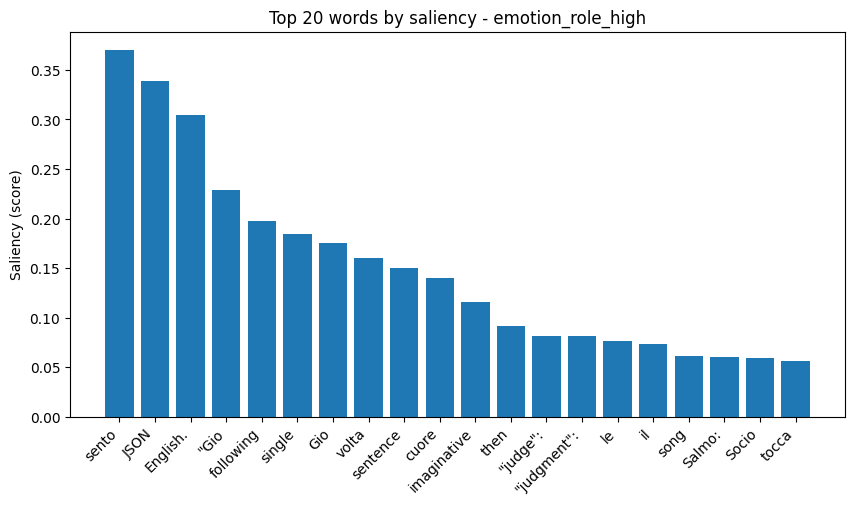


=== meta-llama/Llama-3.2-3B-Instruct | lorenzo_trionfo | presenter | presenter_wrapup ===


,word,score
0,for,0.394655
1,their,0.305631
2,paragraph.,0.285149
3,ONLY,0.267878
4,following,0.253885
5,Three,0.238396
6,che,0.231303
7,paragraph,0.221475
8,are,0.220231
9,The,0.216384


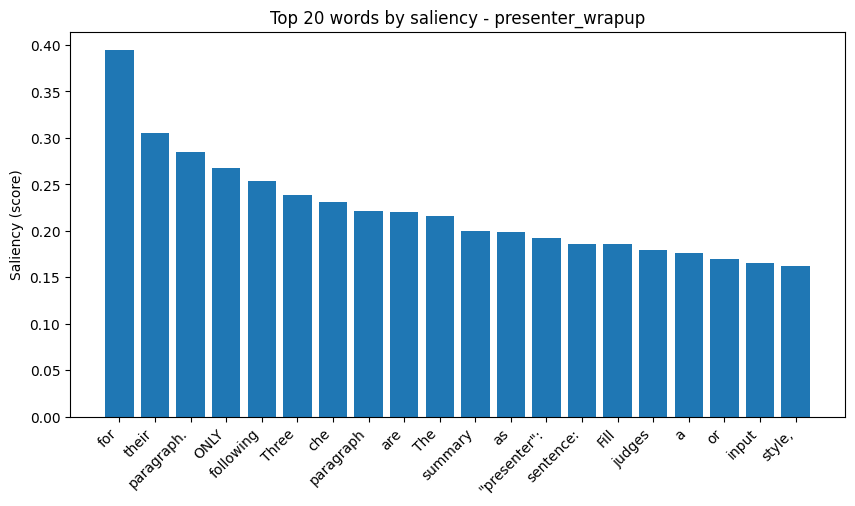

In [29]:
report_saliency(saliency_llama)

### Save Locally

In [ ]:
drive_path = "/content/drive/MyDrive/output_PAOLA/llama_saliencyv2.jsonl"
with open(drive_path, "w", encoding="utf-8") as f:
    for r in saliency_llama:
        f.write(json.dumps(r, ensure_ascii=False) + "\n")
df_saliency_llama = pd.DataFrame(saliency_llama)
df_saliency_llama.to_excel("llama_saliency.xlsx", index=False)
drive_path = "/content/drive/MyDrive/output_PAOLA/llama_saliencyv2.xlsx"
df_saliency_llama.to_excel(drive_path, index=False)


# **FALCOL 3 1B Instruct**

In [30]:
model_id = "tiiuae/Falcon3-1B-Instruct-1.58bit"
tokenizer, model = load_model(model_id)

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/118 [00:00<?, ?B/s]

In [31]:
df_falcon_creative = output_pipeline(model_id, tokenizer, model, "creative")
df_falcon_controlled = output_pipeline(model_id, tokenizer, model, "controlled")

df_falcon = pd.concat([df_falcon_creative, df_falcon_controlled], ignore_index=True)

Running tiiuae/Falcon3-1B-Instruct-1.58bit (creative):   0%|                 | 0/24 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:2509: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:2509: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:2509: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
Running tiiuae/Falcon3-1B-Instruct-1.58bit (creative):   4%|▍        | 1/24 [00:23<09:02, 23.57s/it]Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
Running tiiuae/Falcon3-1B-Instruct-1.58bit (creative):   8%|▊        | 2/24 [00:32<05:26, 14.83s/it]Setting `pad_token_id` to `eos_token_id`:11 fo

In [32]:
df_falcon.to_json("falcon_outputsv2.jsonl", orient="records", lines=True, force_ascii=False)
drive_path = "/content/drive/MyDrive/output_PAOLA/falcon_outputsv2.jsonl"
df_falcon.to_json(drive_path, orient="records", lines=True, force_ascii=False)

df_falcon.to_excel ("falcon_outputsv2.xlsx", index=False)
df_falcon.to_excel("/content/drive/MyDrive/output_PAOLA/falcon_outputsv2.xlsx", index=False)

In [33]:
report(df_falcon)


=== Summary metrics ===


length_tokens         distinct2        avg_logprob        entropy        min_logprob        avg_surprisal         \
                           mean     std      mean    std        mean    std    mean    std        mean    std          mean    std   
mode                                                                                                                                 
emotion_role_high        75.167  27.379     0.758  0.330      -0.317  0.289   0.313  0.294      -3.448  1.428         0.317  0.289   
presenter_wrapup        100.250  29.624     0.845  0.189      -0.314  0.294   0.362  0.324      -3.184  1.534         0.314  0.294   
role                     86.000  48.645     0.756  0.281      -0.430  0.347   0.420  0.329      -3.675  1.734         0.430  0.347   
zero_shot                96.750  43.313     0.564  0.311      -0.230  0.151   0.225  0.155      -3.656  1.524         0.230  0.151   

                  avg_margin        json_valid        json_valid_pct  
                        mean    std       mean    std                 
mode                                                                  
emotion_role_high      0.842  0.116      0.583  0.515         58.333  
presenter_wrapup       0.813  0.118      0.500  0.577         50.000  
role                   0.784  0.127      0.167  0.389         16.667  
zero_shot              0.883  0.058      0.500  0.522         50.000


--- Outputs for zero_shot Sample ---


,model_id,text_id,judge_id,mode,param_set,json_valid,length_tokens,distinct2,avg_logprob,entropy,min_logprob,avg_surprisal,avg_margin
0,tiiuae/Falcon3-1B-Instruct-1.58bit,salmo_the_island,gio_evan,zero_shot,creative,False,106,0.200000,-0.263009,0.289811,-5.048404,0.263009,0.880333
1,tiiuae/Falcon3-1B-Instruct-1.58bit,salmo_the_island,pucci,zero_shot,creative,True,53,1.000000,-0.265532,0.232930,-5.449623,0.265532,0.902727
2,tiiuae/Falcon3-1B-Instruct-1.58bit,salmo_the_island,ursula,zero_shot,creative,True,56,1.000000,-0.394600,0.410110,-4.481921,0.394600,0.806081
3,tiiuae/Falcon3-1B-Instruct-1.58bit,lorenzo_trionfo,gio_evan,zero_shot,creative,False,73,0.277778,-0.346528,0.288773,-5.433293,0.346528,0.876807
4,tiiuae/Falcon3-1B-Instruct-1.58bit,lorenzo_trionfo,pucci,zero_shot,creative,True,72,0.802817,-0.501104,0.504142,-4.802032,0.501104,0.805097



--- Outputs for role Sample ---


,model_id,text_id,judge_id,mode,param_set,json_valid,length_tokens,distinct2,avg_logprob,entropy,min_logprob,avg_surprisal,avg_margin
0,tiiuae/Falcon3-1B-Instruct-1.58bit,salmo_the_island,gio_evan,role,creative,True,35,1.000000,-0.563559,0.558779,-4.858336,0.563559,0.735557
1,tiiuae/Falcon3-1B-Instruct-1.58bit,salmo_the_island,pucci,role,creative,False,46,1.000000,-0.798231,0.754615,-4.804725,0.798231,0.657988
2,tiiuae/Falcon3-1B-Instruct-1.58bit,salmo_the_island,ursula,role,creative,False,99,0.887755,-0.721653,0.689337,-5.580756,0.721653,0.659597
3,tiiuae/Falcon3-1B-Instruct-1.58bit,lorenzo_trionfo,gio_evan,role,creative,True,104,0.660194,-0.593263,0.612139,-5.560911,0.593263,0.709358
4,tiiuae/Falcon3-1B-Instruct-1.58bit,lorenzo_trionfo,pucci,role,creative,False,45,0.954545,-1.015586,0.989996,-5.664290,1.015586,0.604451



--- Outputs for emotion_role_high Sample ---


,model_id,text_id,judge_id,mode,param_set,json_valid,length_tokens,distinct2,avg_logprob,entropy,min_logprob,avg_surprisal,avg_margin
0,tiiuae/Falcon3-1B-Instruct-1.58bit,salmo_the_island,gio_evan,emotion_role_high,creative,True,77,0.842105,-0.440738,0.344592,-5.176778,0.440738,0.819123
1,tiiuae/Falcon3-1B-Instruct-1.58bit,salmo_the_island,pucci,emotion_role_high,creative,True,49,1.000000,-0.106316,0.117337,-3.425737,0.106316,0.934977
2,tiiuae/Falcon3-1B-Instruct-1.58bit,salmo_the_island,ursula,emotion_role_high,creative,True,58,1.000000,-0.640741,0.773179,-4.467455,0.640741,0.639098
3,tiiuae/Falcon3-1B-Instruct-1.58bit,lorenzo_trionfo,gio_evan,emotion_role_high,creative,True,40,0.974359,-0.632372,0.617430,-4.366117,0.632372,0.721225
4,tiiuae/Falcon3-1B-Instruct-1.58bit,lorenzo_trionfo,pucci,emotion_role_high,creative,True,71,1.000000,-0.723736,0.691802,-5.500236,0.723736,0.683446



--- Outputs for presenter_wrapup Sample ---


,model_id,text_id,judge_id,mode,param_set,json_valid,length_tokens,distinct2,avg_logprob,entropy,min_logprob,avg_surprisal,avg_margin
0,tiiuae/Falcon3-1B-Instruct-1.58bit,salmo_the_island,presenter,presenter_wrapup,creative,True,72,0.577465,-0.272135,0.342213,-4.327663,0.272135,0.845206
1,tiiuae/Falcon3-1B-Instruct-1.58bit,lorenzo_trionfo,presenter,presenter_wrapup,creative,True,94,0.989247,-0.739251,0.822240,-4.671712,0.739251,0.644248
2,tiiuae/Falcon3-1B-Instruct-1.58bit,salmo_the_island,presenter,presenter_wrapup,controlled,False,142,0.964539,-0.166087,0.190822,-2.069443,0.166087,0.845495
3,tiiuae/Falcon3-1B-Instruct-1.58bit,lorenzo_trionfo,presenter,presenter_wrapup,controlled,False,93,0.847826,-0.079674,0.092413,-1.667477,0.079674,0.918374


### Saliency

Running saliency tiiuae/Falcon3-1B-Instruct-1.58bit:   0%|                    | 0/2 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.

  salmo_the_island-emotion_role_high:   0%|             | 0/135 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.

  salmo_the_island-emotion_role_high:   1%|     | 1/135 [00:21<47:19, 21.19s/it]Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.

  salmo_the_island-emotion_role_high:   1%|     | 2/135 [00:42<46:39, 21.05s/it]Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.

  salmo_the_island-emotion_role_high:   2%|     | 3/135 [00:54<37:49, 17.19s/it]Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.

  salmo_the_island-emotion_role_high:   3%|▏    | 4/135 [01:15<40:51, 18.71s/it]Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.

  salmo_the_island-emotion_role_high:   4%|▏    | 5/135 [01:36<42:02, 19.41s/it]


=== tiiuae/Falcon3-1B-Instruct-1.58bit | salmo_the_island | gio_evan | emotion_role_high ===


,word,score
0,"Evan"",",1.029973
1,single,1.009767
2,should,0.860549
3,fai,0.833627
4,sensitivity.,0.739907
5,l'alba,0.729211
6,language.,0.681878
7,English.,0.648831
8,Gio,0.580743
9,d'estate,0.569424


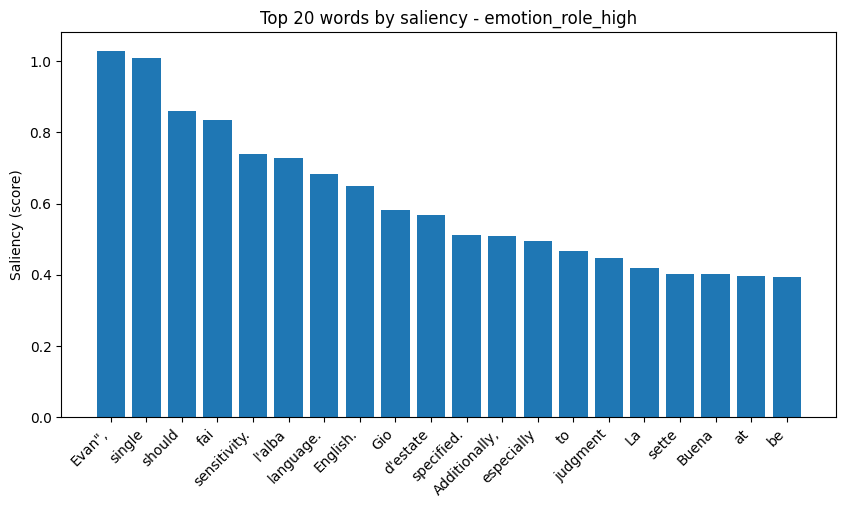


=== tiiuae/Falcon3-1B-Instruct-1.58bit | lorenzo_trionfo | presenter | presenter_wrapup ===


,word,score
0,"""""""Quant’è",1.249055
1,include,1.186888
2,Talent,1.059226
3,von,1.039979
4,"""overall_emotion"":",1.013127
5,IMPORTANT:,0.994743
6,a,0.974294
7,starting,0.954872
8,Always,0.939201
9,poem,0.937227


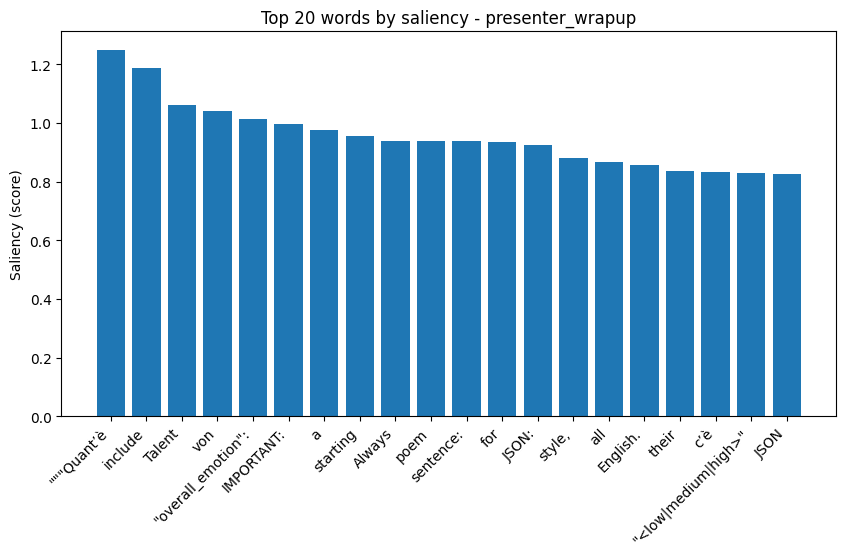

In [34]:
saliency_falcon = saliency(model_id, tokenizer, model, param_sets, texts, judges)
with open("falcon_saliencyv1.jsonl", "w", encoding="utf-8") as f:
    for r in saliency_falcon:
        f.write(json.dumps(r, ensure_ascii=False) + "\n")

report_saliency(saliency_falcon)

### Save Locally

In [35]:
drive_jsonl = "/content/drive/MyDrive/output_PAOLA/falcon_saliencyv2.jsonl"
with open(drive_jsonl, "w", encoding="utf-8") as f:
    for r in saliency_falcon:
        f.write(json.dumps(r, ensure_ascii=False) + "\n")

df_saliency_falcon = pd.DataFrame(saliency_falcon)
df_saliency_falcon.to_excel("falcon_saliency.xlsx", index=False)

drive_xlsx = "/content/drive/MyDrive/output_PAOLA/falcon_saliencyv1.xlsx"
df_saliency_falcon.to_excel(drive_xlsx, index=False)

# **MISTRAL 7B-INSTRUCT**

In [16]:
!pip install -q bitsandbytes accelerate transformers peft

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_conflicts
    package_set, _ = create_package_set_from_installed()
              

Exception ignored in: <function _xla_gc_callback at 0x7ee27cee5800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


In [17]:
bnb = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

model_id   = "mistralai/Mistral-7B-Instruct-v0.1"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.2",
    device_map="auto",
    quantization_config=bnb,
    use_cache=False
).eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [18]:
df_mistral_creative = output_pipeline(model_id, tokenizer, model, "creative")
df_mistral_controlled = output_pipeline(model_id, tokenizer, model, "controlled")

df_mistral = pd.concat([df_mistral_creative, df_mistral_controlled], ignore_index=True)

Running mistralai/Mistral-7B-Instruct-v0.1 (creative):   0%|                 | 0/24 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Running mistralai/Mistral-7B-Instruct-v0.1 (creative):   4%|▍        | 1/24 [00:14<05:27, 14.26s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Running mistralai/Mistral-7B-Instruct-v0.1 (creative):   8%|▊        | 2/24 [00:22<04:00, 10.93s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Running mistralai/Mistral-7B-Instruct-v0.1 (creative):  12%|█▏       | 3/24 [00:30<03:21,  9.60s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Running mistralai/Mistral-7B-Instruct-v0.1 (creative):  17%|█▌       | 4/24 [00:43<03:36, 10.80s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Running mistralai/Mistral-7B-Instruct-v0.1 (creative):  21%|█▉       | 5/24 [00:50<02:56,  9.28s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end gene

In [19]:
df_mistral.to_json("mistral_outputsv1.jsonl", orient="records", lines=True, force_ascii=False)
drive_path = "/content/drive/MyDrive/output_PAOLA/mistral_outputsv1.jsonl"
df_mistral.to_json(drive_path, orient="records", lines=True, force_ascii=False)
report(df_mistral)

In [20]:
df_mistral.to_excel ("mistral_outputsv1.xlsx", index=False)
df_mistral.to_excel("/content/drive/MyDrive/output_PAOLA/mistral_outputsv1.xlsx", index=False)

### **Saliency**

Running saliency mistralai/Mistral-7B-Instruct-v0.1:   0%|                    | 0/2 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.

  salmo_the_island-emotion_role_high:   0%|             | 0/135 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.

  salmo_the_island-emotion_role_high:   1%|     | 1/135 [00:06<13:31,  6.06s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.

  salmo_the_island-emotion_role_high:   1%|     | 2/135 [00:12<14:11,  6.40s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.

  salmo_the_island-emotion_role_high:   2%|     | 3/135 [00:24<19:23,  8.82s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.

  salmo_the_island-emotion_role_high:   3%|▏    | 4/135 [00:34<19:59,  9.16s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.

  salmo_the_island-emotion_role_high:   4%|▏    | 5/135 [00:42<18:54,  8.73s/it]Settin


=== mistralai/Mistral-7B-Instruct-v0.1 | salmo_the_island | gio_evan | emotion_role_high ===


,word,score
0,answer,0.189429
1,not,0.177300
2,emotion,0.174053
3,a,0.170103
4,sentence,0.167787
5,"""<low|medium|high>"",",0.163815
6,object,0.156356
7,Provide,0.148263
8,the,0.140945
9,are,0.139365


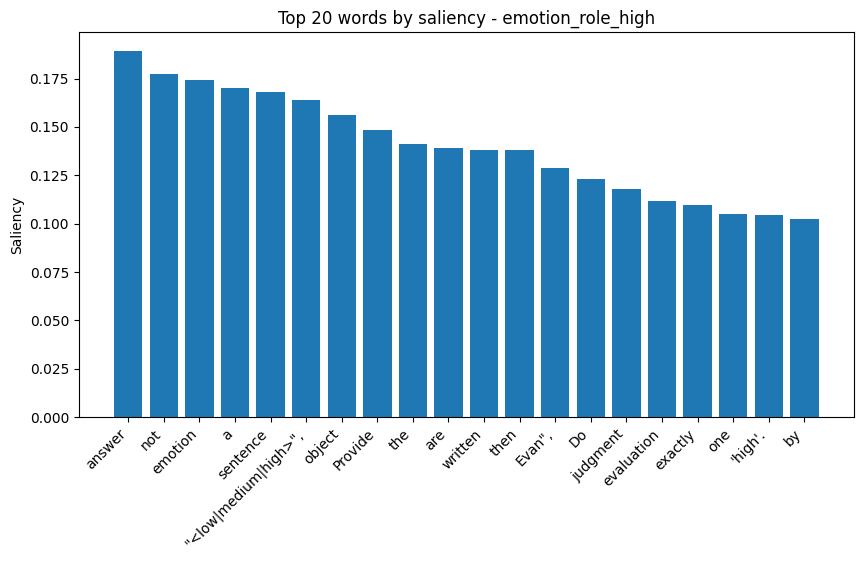


=== mistralai/Mistral-7B-Instruct-v0.1 | lorenzo_trionfo | presenter | presenter_wrapup ===


,word,score
0,English.,0.201205
1,"explanations,",0.148305
2,"""Thank",0.145345
3,"Evan,",0.140276
4,as,0.134145
5,"wrap-up>"",",0.126905
6,all,0.123455
7,wrap-up,0.120406
8,Answer,0.112083
9,Markdown.,0.109089


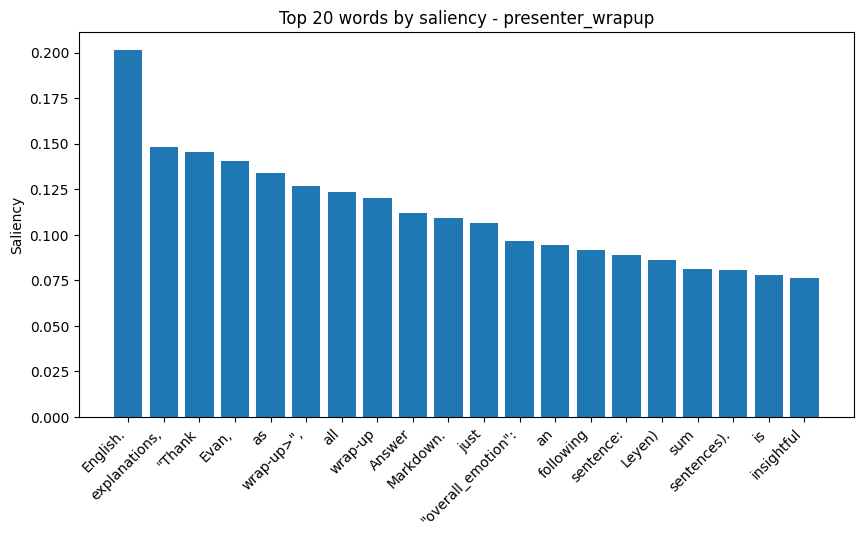

In [21]:
saliency_mistral = saliency(model_id, tokenizer, model, param_sets, texts, judges)
with open("mistral_saliencyv1.jsonl", "w", encoding="utf-8") as f:
    for r in saliency_mistral:
        f.write(json.dumps(r, ensure_ascii=False) + "\n")

report_saliency(saliency_mistral)


### Save Locally

In [22]:
drive_jsonl = "/content/drive/MyDrive/output_PAOLA/mistral_saliencyv1.jsonl"
with open(drive_jsonl, "w", encoding="utf-8") as f:
    for r in saliency_mistral:
        f.write(json.dumps(r, ensure_ascii=False) + "\n")

df_saliency_mistral = pd.DataFrame(saliency_mistral)
df_saliency_mistral.to_excel("mistral_saliencyv1.xlsx", index=False)

drive_xlsx = "/content/drive/MyDrive/output_PAOLA/mistral_saliencyv1.xlsx"
df_saliency_mistral.to_excel(drive_xlsx, index=False)

# **HERMES-2-PRO-MISTRAL-7B**

In [ ]:
!pip install -q bitsandbytes accelerate transformers peft

In [23]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

model_id = "NousResearch/Hermes-2-Pro-Mistral-7B"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=bnb_config,
    torch_dtype=torch.bfloat16,
    offload_folder="offload",
    offload_buffers=True,
    use_cache=True
).eval()

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/643 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.93G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.93G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.68G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

In [24]:
df_hermes_creative   = output_pipeline(model_id, tokenizer, model, "creative")
df_hermes_controlled = output_pipeline(model_id, tokenizer, model, "controlled")
df_hermes = pd.concat([df_hermes_creative, df_hermes_controlled], ignore_index=True)

report(df_hermes)


Running NousResearch/Hermes-2-Pro-Mistral-7B (creative):   0%|               | 0/24 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.
Running NousResearch/Hermes-2-Pro-Mistral-7B (creative):   4%|▎      | 1/24 [00:10<04:08, 10.80s/it]Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.
Running NousResearch/Hermes-2-Pro-Mistral-7B (creative):   8%|▌      | 2/24 [00:28<05:29, 14.96s/it]Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.
Running NousResearch/Hermes-2-Pro-Mistral-7B (creative):  12%|▉      | 3/24 [00:47<05:48, 16.60s/it]Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.
Running NousResearch/Hermes-2-Pro-Mistral-7B (creative):  17%|█▏     | 4/24 [01:05<05:44, 17.22s/it]Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.
Running NousResearch/Hermes-2-Pro-Mistral-7B (creative):  21%|█▍     | 5/24 [01:15<04:37, 14.61s/it]Setting `pad_token_id` to `eos_token_id`


=== Summary metrics ===


length_tokens         distinct2        avg_logprob        entropy        min_logprob        avg_surprisal         \
                           mean     std      mean    std        mean    std    mean    std        mean    std          mean    std   
mode                                                                                                                                 
emotion_role_high        92.000  39.697     0.875  0.170      -0.211  0.191   0.202  0.180      -3.001  1.201         0.211  0.191   
presenter_wrapup         89.250  11.871     0.905  0.121      -0.145  0.128   0.150  0.124      -2.715  1.295         0.145  0.128   
role                     95.917  20.505     0.919  0.065      -0.210  0.156   0.205  0.150      -3.091  1.493         0.210  0.156   
zero_shot                92.750  26.289     0.885  0.090      -0.168  0.124   0.178  0.125      -2.735  1.371         0.168  0.124   

                  avg_margin        json_valid      json_valid_pct  
                        mean    std       mean  std                 
mode                                                                
emotion_role_high      0.875  0.087        1.0  0.0          100.0  
presenter_wrapup       0.896  0.082        1.0  0.0          100.0  
role                   0.871  0.070        1.0  0.0          100.0  
zero_shot              0.883  0.065        1.0  0.0          100.0


--- Outputs for zero_shot Sample ---


,model_id,text_id,judge_id,mode,param_set,json_valid,length_tokens,distinct2,avg_logprob,entropy,min_logprob,avg_surprisal,avg_margin
0,NousResearch/Hermes-2-Pro-Mistral-7B,salmo_the_island,gio_evan,zero_shot,creative,True,63,1.000000,-0.373327,0.329608,-4.488609,0.373327,0.804197
1,NousResearch/Hermes-2-Pro-Mistral-7B,salmo_the_island,pucci,zero_shot,creative,True,62,1.000000,-0.340274,0.386150,-4.010785,0.340274,0.776212
2,NousResearch/Hermes-2-Pro-Mistral-7B,salmo_the_island,ursula,zero_shot,creative,True,104,0.689320,-0.182690,0.174470,-5.000322,0.182690,0.888794
3,NousResearch/Hermes-2-Pro-Mistral-7B,lorenzo_trionfo,gio_evan,zero_shot,creative,True,130,0.930233,-0.257350,0.269395,-3.152102,0.257350,0.831693
4,NousResearch/Hermes-2-Pro-Mistral-7B,lorenzo_trionfo,pucci,zero_shot,creative,True,72,0.845070,-0.231738,0.266047,-2.871516,0.231738,0.849101



--- Outputs for role Sample ---


,model_id,text_id,judge_id,mode,param_set,json_valid,length_tokens,distinct2,avg_logprob,entropy,min_logprob,avg_surprisal,avg_margin
0,NousResearch/Hermes-2-Pro-Mistral-7B,salmo_the_island,gio_evan,role,creative,True,93,0.826087,-0.255549,0.221762,-4.063667,0.255549,0.868986
1,NousResearch/Hermes-2-Pro-Mistral-7B,salmo_the_island,pucci,role,creative,True,64,1.000000,-0.469228,0.468146,-5.288018,0.469228,0.761425
2,NousResearch/Hermes-2-Pro-Mistral-7B,salmo_the_island,ursula,role,creative,True,126,0.936000,-0.411825,0.428588,-4.964595,0.411825,0.754475
3,NousResearch/Hermes-2-Pro-Mistral-7B,lorenzo_trionfo,gio_evan,role,creative,True,90,0.831461,-0.406448,0.364840,-4.831026,0.406448,0.801625
4,NousResearch/Hermes-2-Pro-Mistral-7B,lorenzo_trionfo,pucci,role,creative,True,93,0.956522,-0.295549,0.248084,-3.956808,0.295549,0.846637



--- Outputs for emotion_role_high Sample ---


,model_id,text_id,judge_id,mode,param_set,json_valid,length_tokens,distinct2,avg_logprob,entropy,min_logprob,avg_surprisal,avg_margin
0,NousResearch/Hermes-2-Pro-Mistral-7B,salmo_the_island,gio_evan,emotion_role_high,creative,True,128,0.984252,-0.489232,0.457936,-4.534171,0.489232,0.745481
1,NousResearch/Hermes-2-Pro-Mistral-7B,salmo_the_island,pucci,emotion_role_high,creative,True,124,0.975610,-0.513167,0.499059,-4.692247,0.513167,0.739176
2,NousResearch/Hermes-2-Pro-Mistral-7B,salmo_the_island,ursula,emotion_role_high,creative,True,123,0.950820,-0.505419,0.438500,-4.146640,0.505419,0.768593
3,NousResearch/Hermes-2-Pro-Mistral-7B,lorenzo_trionfo,gio_evan,emotion_role_high,creative,True,117,1.000000,-0.294784,0.299882,-3.725565,0.294784,0.811442
4,NousResearch/Hermes-2-Pro-Mistral-7B,lorenzo_trionfo,pucci,emotion_role_high,creative,True,63,0.483871,-0.217717,0.268594,-3.813248,0.217717,0.847726



--- Outputs for presenter_wrapup Sample ---


,model_id,text_id,judge_id,mode,param_set,json_valid,length_tokens,distinct2,avg_logprob,entropy,min_logprob,avg_surprisal,avg_margin
0,NousResearch/Hermes-2-Pro-Mistral-7B,salmo_the_island,presenter,presenter_wrapup,creative,True,106,0.733333,-0.158744,0.184760,-3.205016,0.158744,0.895370
1,NousResearch/Hermes-2-Pro-Mistral-7B,lorenzo_trionfo,presenter,presenter_wrapup,creative,True,87,1.000000,-0.318748,0.310215,-4.313687,0.318748,0.781929
2,NousResearch/Hermes-2-Pro-Mistral-7B,salmo_the_island,presenter,presenter_wrapup,controlled,True,86,0.976471,-0.029264,0.037251,-1.501929,0.029264,0.970241
3,NousResearch/Hermes-2-Pro-Mistral-7B,lorenzo_trionfo,presenter,presenter_wrapup,controlled,True,78,0.909091,-0.072314,0.068837,-1.839673,0.072314,0.934563


### Save Locally

In [25]:
df_hermes.to_json("hermes_outputs.jsonl", orient="records", lines=True, force_ascii=False)
df_hermes.to_json("/content/drive/MyDrive/output_PAOLA/hermes_outputs.jsonl", orient="records", lines=True, force_ascii=False)
df_hermes.to_excel("hermes_outputs.xlsx", index=False)
df_hermes.to_excel("/content/drive/MyDrive/output_PAOLA/hermes_outputs.xlsx", index=False)

### Saliency

Running saliency NousResearch/Hermes-2-Pro-Mistral-7B:   0%|                  | 0/2 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.

  salmo_the_island-emotion_role_high:   0%|             | 0/135 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.

  salmo_the_island-emotion_role_high:   1%|     | 1/135 [00:17<40:05, 17.95s/it]Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.

  salmo_the_island-emotion_role_high:   1%|     | 2/135 [00:35<39:49, 17.97s/it]Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.

  salmo_the_island-emotion_role_high:   2%|     | 3/135 [00:42<28:27, 12.94s/it]Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.

  salmo_the_island-emotion_role_high:   3%|▏    | 4/135 [00:51<24:13, 11.09s/it]Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.

  salmo_the_island-emotion_role_high:   4%|▏    | 5/135 [00:59


=== NousResearch/Hermes-2-Pro-Mistral-7B | salmo_the_island | gio_evan | emotion_role_high ===


,word,score
0,sensitivity.,0.765147
1,object,0.638643
2,Socio,0.602190
3,or,0.584559
4,"""<low|medium|high>"",",0.577178
5,evaluate,0.542550
6,sento,0.416886
7,emphasize,0.405400
8,especially,0.404239
9,judgment,0.227480


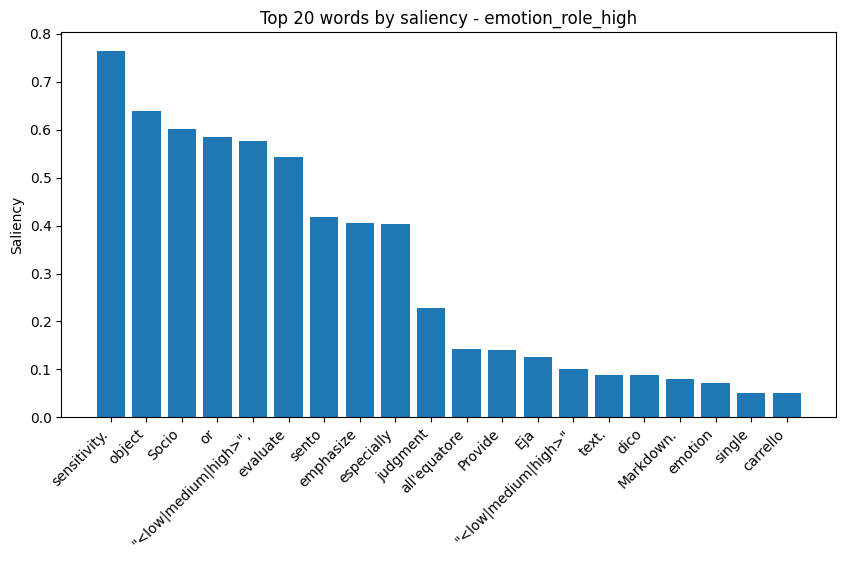


=== NousResearch/Hermes-2-Pro-Mistral-7B | lorenzo_trionfo | presenter | presenter_wrapup ===


,word,score
0,following,0.666562
1,text.,0.443429
2,"""Thank",0.440047
3,You,0.348417
4,judgments,0.333175
5,der,0.326265
6,their,0.325688
7,must,0.305052
8,IMPORTANT:,0.286500
9,"""summary""",0.285924


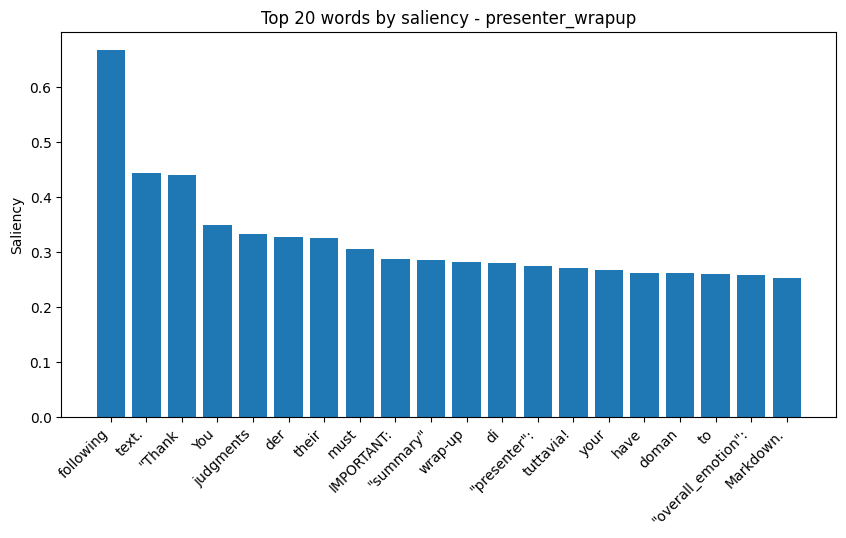

In [26]:
df_saliency_hermes = saliency(model_id, tokenizer, model, param_sets, texts, judges)
report_saliency(df_saliency_hermes)


In [27]:
df_saliency_hermes.to_json("hermes_saliency.jsonl", orient="records", lines=True, force_ascii=False)
df_saliency_hermes.to_json("/content/drive/MyDrive/output_PAOLA/hermes_saliency.jsonl", orient="records", lines=True, force_ascii=False)
df_saliency_hermes.to_excel("hermes_saliency.xlsx", index=False)
df_saliency_hermes.to_excel("/content/drive/MyDrive/output_PAOLA/hermes_saliency.xlsx", index=False)

AttributeError: 'list' object has no attribute 'to_json'

# **GPT 2** 

In [ ]:
model_id = "openai-community/gpt2-large"
tokenizer, model = load_model(model_id)

In [ ]:
df_gpt2_creative   = output_pipeline(model_id, tokenizer, model, "creative")
df_gpt2_controlled = output_pipeline(model_id, tokenizer, model, "controlled")
df_gpt2 = pd.concat([df_gpt2_creative, df_gpt2_controlled], ignore_index=True)

report(df_gpt2)


In [ ]:
df_gpt2.to_json("gpt2_large_outputs.jsonl", orient="records", lines=True, force_ascii=False)
df_gpt2.to_excel("gpt2_large_outputs.xlsx", index=False)

drive_dir = "/content/drive/MyDrive/output_PAOLA"
os.makedirs(drive_dir, exist_ok=True)
df_gpt2.to_json(f"{drive_dir}/gpt2_large_outputs.jsonl", orient="records", lines=True, force_ascii=False)
df_gpt2.to_excel(f"{drive_dir}/gpt2_large_outputs.xlsx", index=False)

In [ ]:
saliency_gpt2 = saliency(model_id, tokenizer, model, param_sets, texts, judges)
report_saliency(saliency_gpt2)
with open("gpt2_large_saliency.jsonl", "w", encoding="utf-8") as f:
    for rec in saliency_gpt2:
        f.write(json.dumps(rec, ensure_ascii=False) + "\n")


In [ ]:
pd.DataFrame(saliency_gpt2).to_excel("gpt2_large_saliency.xlsx", index=False)

drive_dir = "/content/drive/MyDrive/output_PAOLA"
os.makedirs(drive_dir, exist_ok=True)
with open(f"{drive_dir}/gpt2_large_saliency.jsonl", "w", encoding="utf-8") as f:
    for rec in saliency_gpt2:
        f.write(json.dumps(rec, ensure_ascii=False) + "\n")
pd.DataFrame(saliency_gpt2).to_excel(f"{drive_dir}/gpt2_large_saliency.xlsx", index=False)